In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Loading Dataset and Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/AI&ML/WEEK8/trum_tweet_sentiment_analysis.csv')

In [5]:
data.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [6]:
# Preprocessing function
def preprocess_text(text):
  text = text.lower() # Lowercase
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
  text = re.sub(r'\@\w+|\#', '', text) # Remove mentions/hashtags
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'\d+', '', text) # Remove numbers
  # Remove stopwords and lemmatize
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return '' .join(tokens)
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Visualizing WordCloud

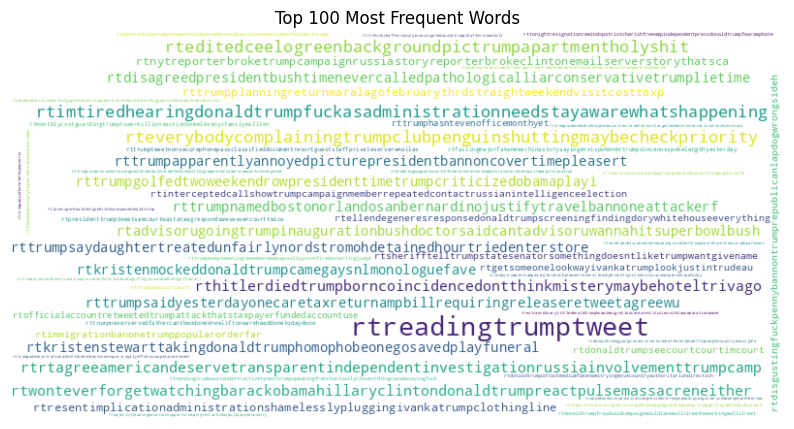

In [7]:
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()


# LabelEncoding and Splitting Dataset

In [8]:
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['sentiment_encoded'],
    test_size=0.2,
    random_state=42
)

# Padding and Tokenization

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# RNN and LSTM Model

**RNN**

In [14]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
early_stop_rnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_rnn = ModelCheckpoint('best_rnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop_rnn, checkpoint_rnn]
)

Epoch 1/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.4059
Epoch 1: val_accuracy improved from -inf to 0.80545, saving model to best_rnn_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7904 - loss: 0.4059 - val_accuracy: 0.8055 - val_loss: 0.3736
Epoch 2/10
18497/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.3762
Epoch 2: val_accuracy did not improve from 0.80545
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8031 - loss: 0.3762 - val_accuracy: 0.8054 - val_loss: 0.3739
Epoch 3/10
18487/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8044 - loss: 0.3748
Epoch 3: val_accuracy did not improve from 0.80545
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.8044 - loss: 0.3748 - val_accuracy: 0.8054 - val_loss: 0.3736
Epoch 4/10
18482/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8035 - loss: 0.3753
Epoch 4: val_accuracy improved from 0.80545 to 0.80546, saving model to best_rnn_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.8035 - loss: 0.3753 - val_accuracy: 0.8055 - val_loss: 0.3735
Epoch 5/10
18482/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8044 - loss: 0.3750
Epoch 5: val_accuracy did not improve from 0.80546
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8044 - loss: 0.3750 - val_accuracy: 0.8055 - val_loss: 0.3737
Epoch 6/10
18495/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.3750
Epoch 6: val_accuracy did not improve from 0.80546
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.8040 - loss: 0.3750 - val_accuracy: 0.8055 - val_loss: 0.3734
Epoch 7/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.3747
Epoch 7: val_accuracy did not improve from 0.80546
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.8041 - loss: 0.3747 - val_accuracy: 0.8054 - val_loss: 0.3736
Epoch 8/10
18493/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.3754

**LSTM**

In [15]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64,
                         validation_split=0.2, callbacks=[early_stop, checkpoint])

Epoch 1/10
18492/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7897 - loss: 0.4068
Epoch 1: val_accuracy improved from -inf to 0.80545, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.7897 - loss: 0.4068 - val_accuracy: 0.8054 - val_loss: 0.3733
Epoch 2/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8042 - loss: 0.3749
Epoch 2: val_accuracy improved from 0.80545 to 0.80546, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 134s 7ms/step - accuracy: 0.8042 - loss: 0.3749 - val_accuracy: 0.8055 - val_loss: 0.3734
Epoch 3/10
18496/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8045 - loss: 0.3741
Epoch 3: val_accuracy did not improve from 0.80546
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - accuracy: 0.8045 - loss: 0.3741 - val_accuracy: 0.8055 - val_loss: 0.3734
Epoch 4/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8037 - loss: 0.3749
Epoch 4: val_accuracy did not improve from 0.80546
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 151s 6ms/step - accuracy: 0.8037 - loss: 0.3749 - val_accuracy: 0.8055 - val_loss: 0.3734


# Model Evaluation

**Simple RNN**

In [21]:
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

print("RNN Accuracy:", accuracy_score(y_test, y_pred_rnn))
print("RNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rnn))
print("RNN Classification Report:\n", classification_report(y_test, y_pred_rnn))


11564/11564 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
RNN Accuracy: 0.8017350179041957
RNN Confusion Matrix:
 [[248537     26]
 [ 73337  48125]]
RNN Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87    248563
           1       1.00      0.40      0.57    121462

    accuracy                           0.80    370025
   macro avg       0.89      0.70      0.72    370025
weighted avg       0.85      0.80      0.77    370025



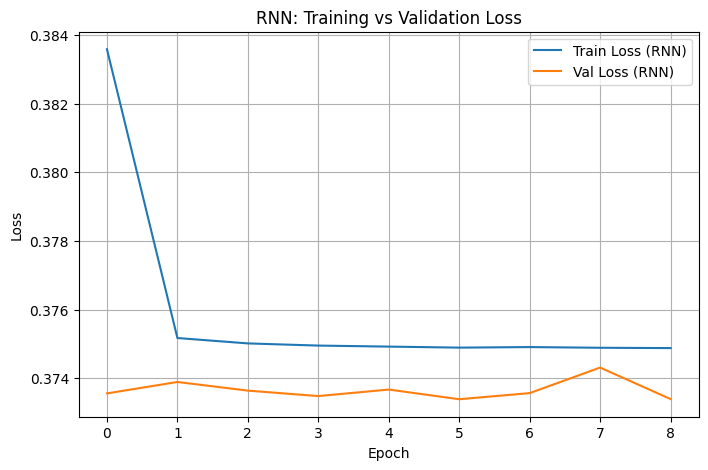

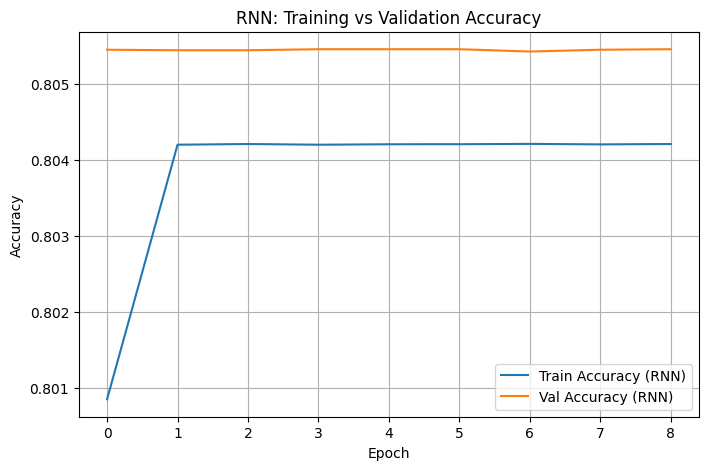

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(history_rnn.history['loss'], label='Train Loss (RNN)')
plt.plot(history_rnn.history['val_loss'], label='Val Loss (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy (RNN)')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**LSTM**

In [17]:
y_pred = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
Accuracy: 0.8017323153840956
Confusion Matrix:
 [[248543     20]
 [ 73344  48118]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87    248563
           1       1.00      0.40      0.57    121462

    accuracy                           0.80    370025
   macro avg       0.89      0.70      0.72    370025
weighted avg       0.85      0.80      0.77    370025



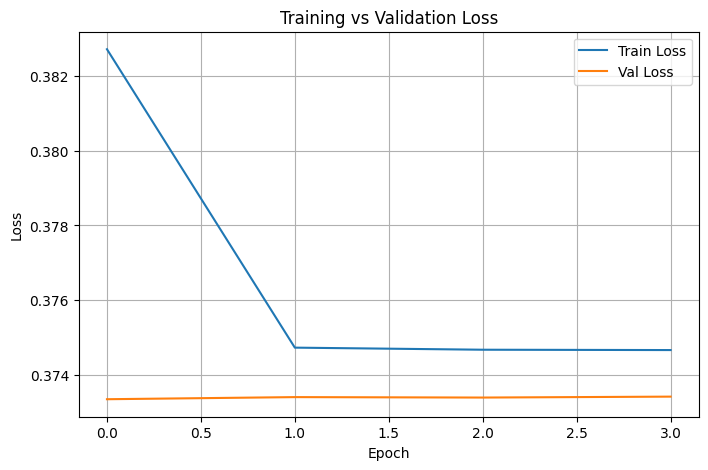

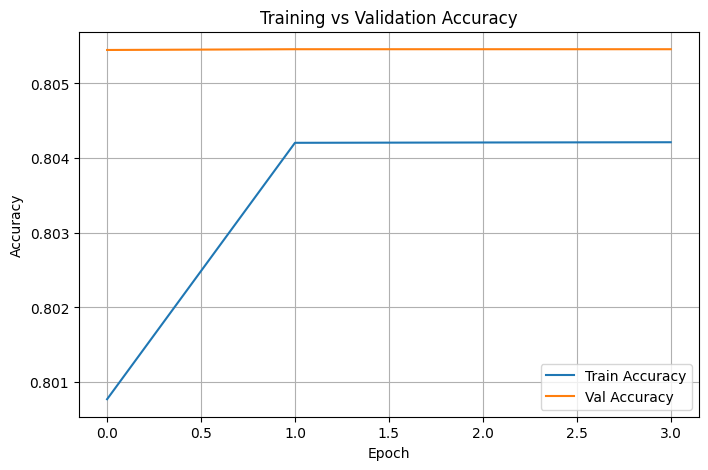

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
